In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from google.colab import drive
import os
import pickle
from scipy.signal import find_peaks, argrelextrema
from scipy.spatial.distance import cdist

In [2]:
def RK4step(func, current_state, t, dt):
    k1 = func(t, current_state)
    k2 = func(t + 0.5 * dt, current_state + 0.5 * dt * k1)
    k3 = func(t + 0.5 * dt, current_state + 0.5 * dt * k2)
    k4 = func(t + dt, current_state + dt * k3)
    return current_state + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

# Lorenz system - Drive

\begin{align*}
\frac{dx}{dt} &= \sigma (y - x) \\
\frac{dy}{dt} &= x (\rho - z) - y \\
\frac{dz}{dt} &= xy - \beta z
\end{align*}

In [3]:
class LorenzSystem:

    def __init__(self):
        self.sigma = 10.0
        self.rho = 28.0
        self.beta = 8.0 / 3.0
        self.state = np.array([1, 1, 1])

    def __call__(self, t, u):
        return np.array([
            self.sigma * (u[1] - u[0]),
            u[0] * (self.rho - u[2]) - u[1],
            u[0] * u[1] - self.beta * u[2]
        ])

    def reinitialise_ic(self):
        self.state = np.array([1, 1, 1])

    def randomise_ic(self):
        self.state = 2 * (np.random.rand(self.state.size) - 0.5)

# Reservoir System - Response
\begin{align*}
\frac{d}{dt}\mathbf{r}(t) = \gamma \left[ -r(t) + \tanh \left( M r(t) + \sigma W_{\text{in}} u(t) \right) \right]
\end{align*}

In [4]:
class ReservoirComputer:
    def __init__(self, drive_system, reservoir_size, connectivity, spectral_radius, gamma, sigma):
        self.rng_M = np.random.default_rng(1911)
        self.rng_Win = np.random.default_rng(1912)
        self.rng_state = np.random.default_rng(1913)

        self.r = 2 * (self.rng_state.random(reservoir_size) - 0.5)
        self.u = drive_system
        self.spectral_radius = spectral_radius
        self.connectivity = connectivity
        self.reservoir_size = reservoir_size

        self.M, self.original_M, self.sparsification_mask = self.generate_matrix_and_mask(reservoir_size, connectivity, spectral_radius)
        self.Win = self.generate_Win(reservoir_size, self.u.state.size)

        self.sigma = sigma
        self.gamma = gamma
        self.res_update_func_listen = self.reservoir_update_equation
        self.res_update_func_pred = self.reservoir_update_equation_prediction

        self.dt = 0.01
        self.t = 0.0
        self.beta = 0.001
        self.q = lambda x: np.concatenate((np.array(x), np.array(x)**2))
        self.A = None
        self.b = None
        self.phi = None

    def generate_matrix_and_mask(self, reservoir_size, connectivity, spectral_radius):
        M = 2 * (self.rng_M.random((reservoir_size, reservoir_size)) - 0.5)
        sparsification_mask = self.rng_M.binomial(1, connectivity, size=(reservoir_size, reservoir_size))
        original_M = M.copy()
        sparsification_mask_copy = sparsification_mask.copy()
        M *= sparsification_mask
        M *= spectral_radius / max(np.abs(np.linalg.eigvals(M))).real
        return M, original_M, sparsification_mask_copy

    def generate_Win(self, reservoir_size, input_size):
        Win = np.zeros((reservoir_size, input_size))
        random_cols = self.rng_Win.integers(0, input_size, reservoir_size)
        random_values = self.rng_Win.uniform(-1, 1, reservoir_size)
        Win[np.arange(reservoir_size), random_cols] = random_values
        return Win

    def reservoir_update_equation(self, t, r):
        return self.gamma * (-r + np.tanh(self.M @ r + self.sigma * self.Win @ self.u.state))

    def reservoir_update_equation_prediction(self, t, r):
        return self.gamma * (-r + np.tanh(self.M @ r + self.sigma * self.Win @ self.phi(self.q(r))))

    def listen(self, t_listen):
        num_timesteps = int(t_listen / self.dt)

        for _ in range(num_timesteps):
            self.u.state = RK4step(self.u, self.u.state, self.t, self.dt)
            self.r = RK4step(self.res_update_func_listen, self.r, self.t, self.dt)
            self.t += self.dt

    def train(self, t_train):
        num_timesteps = int(t_train / self.dt)

        u_states = []
        symmetry_broken_r_states = []
        for _ in range(num_timesteps):
            self.u.state = RK4step(self.u, self.u.state, self.t, self.dt)
            u_states.append(self.u.state)
            self.r = RK4step(self.res_update_func_listen, self.r, self.t, self.dt)
            symmetry_broken_r_states.append(self.q(self.r))
            self.t += self.dt

        u_states = np.array(u_states)
        symmetry_broken_r_states = np.array(symmetry_broken_r_states)
        self.parameterise_phi(symmetry_broken_r_states, u_states)

    def predict(self, t_predict):
        num_timesteps = int(t_predict / self.dt)

        predictions = [self.phi(self.q(self.r))]
        for _ in range(num_timesteps):
            self.r = RK4step(self.res_update_func_pred, self.r, self.t, self.dt)
            prediction = self.phi(self.q(self.r))
            predictions.append(prediction)
            self.t += self.dt

        return np.array(predictions)

    def parameterise_phi(self, X, Y):
        n = X.shape[0]
        dims_x = X.shape[1]
        dims_y = Y.shape[1]
        A = np.linalg.inv(X.T @ X + self.beta * np.identity(dims_x)) @ X.T @ Y
        b = (1 / n) * np.sum(Y - X @ A, axis=0)
        self.A = A
        self.b = b
        self.phi = lambda x: self.A.T @ x + self.b
        #self.phi = lambda x: x @ self.A + self.b

    def set_spectral_radius(self, spectral_radius):
        if spectral_radius == 0:
            self.M = np.zeros_like(self.original_M)
        else:
            self.M = (self.original_M * self.sparsification_mask) * (spectral_radius / max(np.abs(np.linalg.eigvals(self.original_M * self.sparsification_mask))).real)
        self.spectral_radius = spectral_radius

    def time_ts(self, natural_time):
        return int(natural_time/self.dt)

    def reinitialise_same_RC(self):
        self.reinitialise_state()
        self.u.reinitialise_ic()
        self.A = None
        self.b = None
        self.phi = None

    def reinitialise_state(self):
        self.r = 2 * (self.rng_state.random(self.reservoir_size) - 0.5)
        self.t = 0.0

    def reinitialise_M(self):
        self.M, self.original_M, self.sparsification_mask = self.generate_matrix_and_mask(self.reservoir_size, self.connectivity, self.spectral_radius)

    def reinitialise_Win(self):
        self.Win = self.generate_Win(self.reservoir_size, self.u.state.size)

    def reinitialise_RC(self):
        self.reinitialise_M()
        self.reinitialise_Win()
        self.reinitialise_state()

## The following function `time_ts`converts the time parameter into timestep units

In [5]:
def time_ts(natural_time):
        return int(natural_time/0.01)

# THIS IS THE CLASSIFICATION FUNCTION

In [6]:
def is_fixed_point(traj):
    return np.allclose(traj, traj[0], atol=1e-3)

def is_limit_cycle(traj):
    local_maxima = []
    for i in range(1, len(traj) - 1):
        window = traj[i-1:i+2]
        middle_point = traj[i]
        # Find the local maxima in terms of the x coordinate.
        if middle_point[2] == max(window[0][2], window[1][2], window[2][2]):
            local_maxima.append((i, middle_point))

    # Find the global maximum.
    max_value = float('-inf')
    global_max_index = None
    for index, state in local_maxima:
        # Check if the current state's third value is greater than the current maximum
        if state[2] > max_value:
            max_value = state[2]
            global_max_index = index
    global_max_state = traj[global_max_index]

    # Get the indexes of every point that's value along all coordinates is sufficiently close to the global max.
    filtered_maximalist_indexes = [pos for pos, state in local_maxima if np.allclose(state, global_max_state, atol=0.11)]
    if len(filtered_maximalist_indexes) < 2:
        return False

    # Check if the indexes of each point are the same; the trajectory is kosher.
    differences = np.diff(filtered_maximalist_indexes)
    pattern_detected = False
    if len(differences) > 0:
        full_diff = np.concatenate((differences, differences))
        for start in range(len(differences)):
            if np.array_equal(full_diff[start:start+len(differences)], differences):
                pattern_detected = True
                break

    return pattern_detected

def is_lorenz_attractor(traj):
    x, y, z = traj[:, 0], traj[:, 1], traj[:, 2]
    total_points = len(traj)
    points_within_bounds = (
        np.sum((x >= -20) & (x <= 20)) +
        np.sum((y >= -30) & (y <= 30)) +
        np.sum((z >= -5) & (z <= 55))
    )
    percentage_within_bounds = points_within_bounds / (3 * total_points)
    return percentage_within_bounds >= 0.975

def classify_single_trajectory(traj):
    if is_fixed_point(traj):
        return 0
    elif is_limit_cycle(traj):
        return 1
    elif is_lorenz_attractor(traj):
        return 2
    else:
        return 3

def classify_attractors(trajectories):
    classifications = [classify_single_trajectory(traj) for traj in trajectories]
    return classifications

# This is trimming the simulation data to a minimal number of trajectories (1 representing each attractor)

In [7]:
def global_maxima(traj):
    local_maxima = []
    for i in range(1, len(traj) - 1):
        window = traj[i-1:i+2]
        middle_point = traj[i]
        # Find the local maxima in terms of the x coordinate.
        if middle_point[2] == max(window[0][2], window[1][2], window[2][2]):
            local_maxima.append((i, middle_point))

    # Find the global maximum.
    max_value = float('-inf')
    global_max_index = None
    for index, state in local_maxima:
        # Check if the current state's third value is greater than the current maximum
        if state[2] > max_value:
            max_value = state[2]
            global_max_index = index
    global_max_state = traj[global_max_index]
    return global_max_state


In [8]:
def trim_attractor_trajectories(trajectories):
    # Get the classifications, and create space to store the trimmed attractor trajectories and the trimmed continuation states.
    classifications = classify_attractors(trajectories[:, time_ts(50):])
    trimmed_attractors_dict = {}

    for i, (cls, traj) in enumerate(zip(classifications, trajectories[:, time_ts(50):])):
        traj_maxima = global_maxima(traj)

        if cls not in trimmed_attractors_dict:
            trimmed_attractors_dict[cls] = [(trajectories[i], traj_maxima, i)]

        elif cls != 2:# If its the chaotic lorenz attractor dont bother with the local max calculation as the chaos renders it less deterministic by computer standards with out an arbitrarily long simulation time.
            if all(not np.allclose(traj_maxima, stored_max, atol=1) for _, stored_max, _ in trimmed_attractors_dict[cls]):
                trimmed_attractors_dict[cls].append((trajectories[i], traj_maxima, i))

    for key in trimmed_attractors_dict:
      count = 0
      for value in trimmed_attractors_dict[key]:
        count+=1
      print(f"Class {key} has {count} seperate attractors")

    # Unfold the trimmed_attractors dictionary into the relevant separate lists. (trajectories, trajectory indexs)
    trimmed_trajectories = []
    trimmed_trajectory_indices = []

    for key in trimmed_attractors_dict:
        for traj, _, i in trimmed_attractors_dict[key]:
            trimmed_trajectories.append(traj)
            trimmed_trajectory_indices.append(i)

    return (np.array(trimmed_trajectories), np.array(trimmed_trajectory_indices))

# TEST OF TRIMMING ATTRACTOR DUPLICATES FOR CONTINUATION/PLOTTING

In [ ]:
spectral_radii = np.linspace(0, 0.8, 17)
spectral_radii = [str(p) for p in spectral_radii]
spectral_radii.append('0.85')
spectral_radii.append('0.90')
spectral_radii.append('0.95')
spectral_radii.append('1.00')
spectral_radii.append('1.05')
spectral_radii.append('1.10')
randMatrices = ['M', 'Win']

spectral_radii, randMatrices

(['0.0',
  '0.05',
  '0.1',
  '0.15000000000000002',
  '0.2',
  '0.25',
  '0.30000000000000004',
  '0.35000000000000003',
  '0.4',
  '0.45',
  '0.5',
  '0.55',
  '0.6000000000000001',
  '0.65',
  '0.7000000000000001',
  '0.75',
  '0.8',
  '0.85',
  '0.90',
  '0.95',
  '1.00',
  '1.05',
  '1.10'],
 ['M', 'Win'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

def load_dictionary(file_path):
    with open(file_path, 'rb') as file:
        loaded_dictionary = pickle.load(file)
    print(f"Data loaded successfully from {file_path}")
    return loaded_dictionary

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
p = spectral_radii[1]
randMat = randMatrices[0]
p

'0.05'

In [ ]:
file_path = f'drive/My Drive/bifurcation_analysis_data/{p}_{randMat}.pkl'
trajectories_bulk, _ = load_dictionary(file_path)

Data loaded successfully from drive/My Drive/bifurcation_analysis_data/0.05_M.pkl


In [ ]:
trajectories_bulk.shape

(50, 100, 10001, 3)

In [ ]:
single_trajectory_set = trajectories_bulk[3]
single_trajectory_set.shape

(100, 10001, 3)

In [ ]:
def plot_single_trajectory_set(trajectories):
    plt.figure(figsize=(10, 6))
    for i in range(len(trajectories)):
        t = trajectories[i]
        x1 = t[time_ts(60):, 0]  # Extract x1 values
        x3 = t[time_ts(60):, 2]  # Extract x3 values
        plt.plot(x1, x3)  # Plot x1 vs x3

    plt.xlabel(r'$x_1$')  # Set x-axis label
    plt.ylabel(r'$x_3$')  # Set y-axis label
    plt.show()  # Display the plot

    plt.figure(figsize=(10, 6))

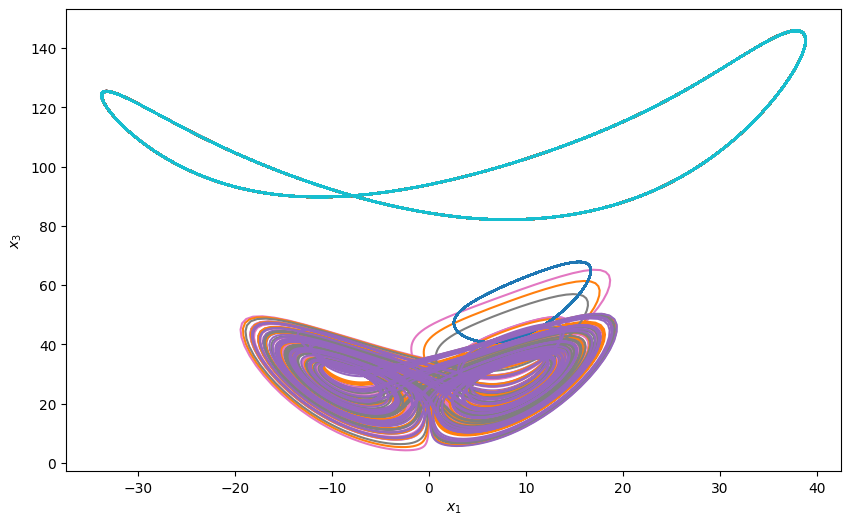

<Figure size 1000x600 with 0 Axes>

In [ ]:
plot_single_trajectory_set(single_trajectory_set)

In [ ]:
trimmed_trajectory_set, _ = trim_attractor_trajectories(single_trajectory_set)
trimmed_trajectory_set.shape

1 and local max [ 37.86628914  22.84324953 146.01927976]
1 and local max [15.50593499  9.19201579 67.84632596]
2 and local max [15.29325886  8.27551303 57.62438205]


(3, 10001, 3)

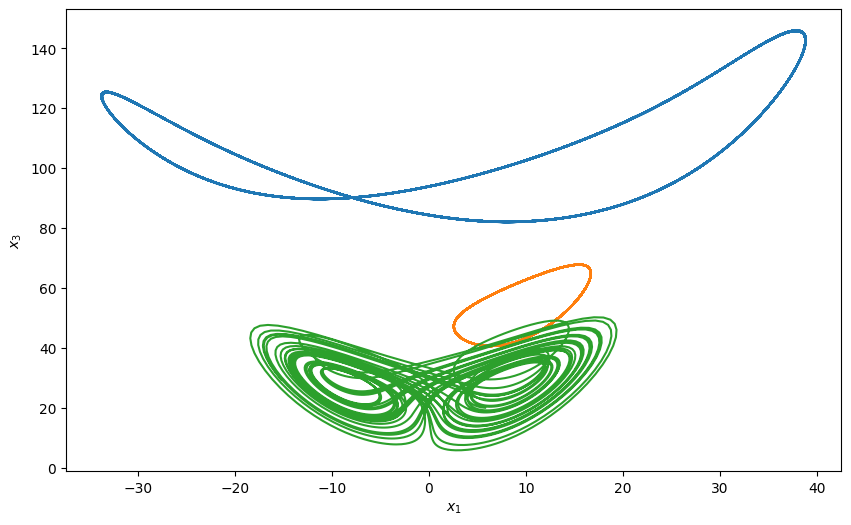

<Figure size 1000x600 with 0 Axes>

In [ ]:
plot_single_trajectory_set(trimmed_trajectory_set)

# Object for RC simulation in bulk.

In [9]:
class ReservoirComputer_BulkSimulation(ReservoirComputer):
    def __init__(self, drive_system, reservoir_size, connectivity, spectral_radius, gamma, sigma):
        super().__init__(drive_system, reservoir_size, connectivity, spectral_radius, gamma, sigma)

    def predict_first_100(self, t_predict):
        predictions_100 = []
        continuation_states = []
        for _ in range(100):
            self.reinitialise_state()
            predictions = self.predict(t_predict)
            predictions_100.append(predictions)
            continuation_states.append(self.r)

        trimmed_attractors, trimmed_trajectory_indices = trim_attractor_trajectories(np.array(predictions_100))
        print("Predictions complete")
        print(trimmed_trajectory_indices)
        return trimmed_attractors, np.array(continuation_states)[list(trimmed_trajectory_indices)]

    def simulate_first_100(self, t_listen, t_train, t_predict):
        self.rng_state = np.random.default_rng(1913)
        self.reinitialise_same_RC()

        self.listen(t_listen)
        self.train(t_train)
        trimmed_attractors, trimmed_continuation_states = self.predict_first_100(t_predict)
        return trimmed_attractors, trimmed_continuation_states

    # Here is the adjustment for continuations
    def predict_from_continuation_n(self, t_predict, previous_continuation_states):
        predictions_n = []
        next_continuation_states = []
        for i in range(len(previous_continuation_states)):
            self.r = previous_continuation_states[i,]
            predictions = self.predict(t_predict)
            predictions_n.append(predictions)
            next_continuation_states.append(self.r)

        print("Predictions complete")
        return np.array(predictions_n), np.array(next_continuation_states)

    def continuation_n(self, t_listen, t_train, t_predict, previous_continuation_states):
        self.rng_state = np.random.default_rng(1913)
        self.reinitialise_same_RC()

        self.listen(t_listen)
        self.train(t_train)
        trajectories, next_continuation_states = self.predict_from_continuation_n(t_predict, previous_continuation_states)
        return np.array(trajectories), np.array(next_continuation_states)

# Poor mans continuation with trimmed attractors exclusively

In [10]:
lorenz = LorenzSystem()                 # U(t)
reservoir_size = 100                    # N
connectivity = 0.05                     # P
spectral_radius = 0.6                   # ρ
gamma = 10.0                            # γ
sigma = 0.2                             # σ

In [11]:
params = (lorenz, reservoir_size, connectivity, spectral_radius, gamma, sigma)

In [12]:
times = (100, 100, 100)

In [13]:
def generate_spectral_radii_list(start, end, steps):
  spectral_radii = np.linspace(start, end, steps)
  spectral_radii = [np.round(p, 6) for p in spectral_radii]
  spectral_radii = [str(p) for p in spectral_radii]
  return spectral_radii

In [14]:
from google.colab import drive
drive.mount('/content/drive')

def load_dictionary(file_path):
    with open(file_path, 'rb') as file:
        loaded_dictionary = pickle.load(file)
    print(f"Data loaded successfully from {file_path}")
    return loaded_dictionary

def save_dictionary(dictionary, file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open(file_path, 'wb') as file:
        pickle.dump(dictionary, file, protocol=pickle.HIGHEST_PROTOCOL)
    print(f'Dictionary saved to {file_path}')

Mounted at /content/drive


In [15]:
def RC_regen_from_seed(params, seed, randomised_parameter):
  RC_B = ReservoirComputer_BulkSimulation(*params)
  if randomised_parameter == "M":
    RC_B.rng_M.bit_generator.state = seed
    RC_B.reinitialise_M()
  else:
    RC_B.rng_Win.bit_generator.state = seed
    RC_B.reinitialise_Win()
  return RC_B

##Simulation from 9th instance of 0.004 down. to 0.002

- Load the seed from the 9th (index = 8) seed for 0.004 and run simulations from that down to o.002 use small jumps to capture 40 steps.

- run again from 0.00365 to 0.00355

In [ ]:
# this is to find out how many steps are necessary to simulate the whole way down.
initial_start = 0.00365
initial_end = 0.00350
steps = 60
step_size = (initial_start - initial_end) / (steps - 1)

initial_start//step_size

1435.0

In [ ]:
# this is to find out the splitting for the bifurcation as we increase rho to see the stabilisation of the lorenz.
initial_start = 0.00365
initial_end = 0.001441
diff = (initial_start - initial_end)/2
diff

initial_start + diff

0.0047545

## Actual simulation here

In [ ]:
# spectral_radii_Lorenz_birth = generate_spectral_radii_list(0.00365, 0.00350, 60)
# spectral_radii_Lorenz_birth = generate_spectral_radii_list(0.00365, 0, 1435)
spectral_radii_Lorenz_birth = generate_spectral_radii_list(0.00365, 0.00475, 434)
spectral_radii = [str(p) for p in spectral_radii_Lorenz_birth]
spectral_radii

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

def load_dictionary(file_path):
    with open(file_path, 'rb') as file:
        loaded_dictionary = pickle.load(file)
    print(f"Data loaded successfully from {file_path}")
    return loaded_dictionary

Mounted at /content/drive


In [ ]:
file_path = f'drive/My Drive/Lorenz_birth_data/0.004_M.pkl'

In [ ]:
_0_0_0_4_data = load_dictionary(file_path)

Data loaded successfully from drive/My Drive/Lorenz_birth_data/0.004_M.pkl


In [ ]:
_, seeds = _0_0_0_4_data
seed = seeds[8]

In [ ]:
def RC_regen_from_seed(params, seed, randomised_parameter):
  RC_B = ReservoirComputer_BulkSimulation(*params)
  if randomised_parameter == "M":
    RC_B.rng_M.bit_generator.state = seed
    RC_B.reinitialise_M()
  else:
    RC_B.rng_Win.bit_generator.state = seed
    RC_B.reinitialise_Win()
  return RC_B

In [ ]:
RC_B = RC_regen_from_seed(params, seed, "M")

trajectories_list = []
continuation_states = []

for i, p in enumerate(spectral_radii):

    RC_B.set_spectral_radius(float(p))
    # just do normal simulation for first parameter as no continuation states to be passed in
    if i == 0:
        trajectories, continuation_states = RC_B.simulate_first_100(*times)
    else:
        trajectories, continuation_states = RC_B.continuation_n(*times, continuation_states)

    # append the attractor to a list to be stored
    trajectories_list.append(trajectories)

    print(f"\033[1mSimulation {i+1}/{len(spectral_radii)} complete for ρ = {p} \033[0m")

result = np.array(trajectories_list)
bifurcation_analysis_data_piece = result

Class 1 has 2 seperate attractors
Class 2 has 1 seperate attractors
Predictions complete
[ 0 74 15]
Simulation 1/434 complete for ρ = 0.00365 
Predictions complete
Simulation 2/434 complete for ρ = 0.003653 
Predictions complete
Simulation 3/434 complete for ρ = 0.003655 
Predictions complete
Simulation 4/434 complete for ρ = 0.003658 
Predictions complete
Simulation 5/434 complete for ρ = 0.00366 
Predictions complete
Simulation 6/434 complete for ρ = 0.003663 
Predictions complete
Simulation 7/434 complete for ρ = 0.003665 
Predictions complete
Simulation 8/434 complete for ρ = 0.003668 
Predictions complete
Simulation 9/434 complete for ρ = 0.00367 
Predictions complete
Simulation 10/434 complete for ρ = 0.003673 
Predictions complete
Simulation 11/434 complete for ρ = 0.003675 
Predictions complete
Simulation 12/434 complete for ρ = 0.003678 
Predictions complete
Simulation 13/434 complete for ρ = 0.00368 
Predictions complete
Simulation 14/434 complete for ρ = 0.003683 
Prediction

In [ ]:
result = np.array(trajectories_list)
bifurcation_analysis_data_piece = result
bifurcation_analysis_data_piece.shape
# completed as far as  this = 0.001441
# this is simulation 869

(869, 3, 10001, 3)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

def save_dictionary(dictionary, file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open(file_path, 'wb') as file:
        pickle.dump(dictionary, file, protocol=pickle.HIGHEST_PROTOCOL)
    print(f'Dictionary saved to {file_path}')

# def save_dictionary_to_drive(dictionary, file_path):
#     full_path = os.path.join('/content/drive/MyDrive', file_path)
#     directory = os.path.dirname(full_path)
#     if not os.path.exists(directory):
#         os.makedirs(directory)
#     with open(full_path, 'wb') as file:
#         pickle.dump(dictionary, file, protocol=pickle.HIGHEST_PROTOCOL)
#     print(f'Dictionary saved to {full_path}')

# def load_dictionary(file_path):
#     with open(file_path, 'rb') as file:
#         loaded_dictionary = pickle.load(file)
#     print(f"Data loaded successfully from {file_path}")
#     return loaded_dictionary

In [ ]:
#file_path = f'drive/My Drive/Lorenz_birth_data/poor_mans_continuation_Lorenz_birth_0.004_to_0.002.pkl'
#file_path = f'drive/My Drive/Lorenz_birth_data/trimmed_poor_mans_continuation_Lorenz_birth_0.00365_to_0.00350.pkl'
# file_path = f'drive/My Drive/Lorenz_birth_data/trimmed_poor_mans_continuation_Lorenz_birth_0.00365_to_0.pkl'
file_path = f'drive/My Drive/Lorenz_birth_data/trimmed_poor_mans_continuation_Lorenz_birth_0.00365_to_0.00475.pkl'
# file_path = f'bifurcation_analysis_data/{p}_{randMat}.pkl'
file_path

'drive/My Drive/Lorenz_birth_data/trimmed_poor_mans_continuation_Lorenz_birth_0.00365_to_0.pkl'

In [ ]:
save_dictionary(bifurcation_analysis_data_piece, file_path)

Dictionary saved to drive/My Drive/Lorenz_birth_data/trimmed_poor_mans_continuation_Lorenz_birth_0.00365_to_0.pkl


# THIS IS THE CONTINUATION FROM across the entire RC from 0.5 in both directions
#potentially with the seed from 0.006M

In [16]:
lorenz = LorenzSystem()                 # U(t)
reservoir_size = 100                    # N
connectivity = 0.05                     # P
spectral_radius = 0.6                   # ρ
gamma = 10.0                            # γ
sigma = 0.2                             # σ

In [17]:
params = (lorenz, reservoir_size, connectivity, spectral_radius, gamma, sigma)

In [18]:
times = (100, 100, 100)

In [19]:
def generate_spectral_radii_list(start, end, steps):
  spectral_radii = np.linspace(start, end, steps)
  spectral_radii = [np.round(p, 6) for p in spectral_radii]
  spectral_radii = [str(p) for p in spectral_radii]
  return spectral_radii

In [20]:
spectral_radii_Lorenz_birth = generate_spectral_radii_list(0, 1, 1001)
spectral_radii = [str(p) for p in spectral_radii_Lorenz_birth]
spectral_radii_cont_down = spectral_radii[:13]
spectral_radii_cont_up = spectral_radii[13:]
spectral_radii_cont_down.reverse()
spectral_radii_cont_up

['0.013',
 '0.014',
 '0.015',
 '0.016',
 '0.017',
 '0.018',
 '0.019',
 '0.02',
 '0.021',
 '0.022',
 '0.023',
 '0.024',
 '0.025',
 '0.026',
 '0.027',
 '0.028',
 '0.029',
 '0.03',
 '0.031',
 '0.032',
 '0.033',
 '0.034',
 '0.035',
 '0.036',
 '0.037',
 '0.038',
 '0.039',
 '0.04',
 '0.041',
 '0.042',
 '0.043',
 '0.044',
 '0.045',
 '0.046',
 '0.047',
 '0.048',
 '0.049',
 '0.05',
 '0.051',
 '0.052',
 '0.053',
 '0.054',
 '0.055',
 '0.056',
 '0.057',
 '0.058',
 '0.059',
 '0.06',
 '0.061',
 '0.062',
 '0.063',
 '0.064',
 '0.065',
 '0.066',
 '0.067',
 '0.068',
 '0.069',
 '0.07',
 '0.071',
 '0.072',
 '0.073',
 '0.074',
 '0.075',
 '0.076',
 '0.077',
 '0.078',
 '0.079',
 '0.08',
 '0.081',
 '0.082',
 '0.083',
 '0.084',
 '0.085',
 '0.086',
 '0.087',
 '0.088',
 '0.089',
 '0.09',
 '0.091',
 '0.092',
 '0.093',
 '0.094',
 '0.095',
 '0.096',
 '0.097',
 '0.098',
 '0.099',
 '0.1',
 '0.101',
 '0.102',
 '0.103',
 '0.104',
 '0.105',
 '0.106',
 '0.107',
 '0.108',
 '0.109',
 '0.11',
 '0.111',
 '0.112',
 '0.113',
 

In [21]:
file_path = f'drive/My Drive/Lorenz_birth_data/0.006_M.pkl'
_0_0_0_6_data = load_dictionary(file_path)
_, seeds = _0_0_0_6_data
seed = seeds[19]

Data loaded successfully from drive/My Drive/Lorenz_birth_data/0.006_M.pkl


In [ ]:
RC_B = RC_regen_from_seed(params, seed, "M")

trajectories_list = []
continuation_states = []

for i, p in enumerate(spectral_radii_cont_up):

    RC_B.set_spectral_radius(float(p))
    # just do normal simulation for first parameter as no continuation states to be passed in
    if i == 0:
        trajectories, continuation_states = RC_B.simulate_first_100(*times)
    else:
        trajectories, continuation_states = RC_B.continuation_n(*times, continuation_states)

    # append the attractor to a list to be stored
    trajectories_list.append(trajectories)

    print(f"\033[1mSimulation {i+1}/{len(spectral_radii_cont_up)} complete for ρ = {p} \033[0m")

result = np.array(trajectories_list)
bifurcation_analysis_data_piece = result

Class 1 has 1 seperate attractors
Class 3 has 1 seperate attractors
Class 2 has 1 seperate attractors
Predictions complete
[ 0  3 26]
Simulation 1/988 complete for ρ = 0.013 
Predictions complete
Simulation 2/988 complete for ρ = 0.014 
Predictions complete
Simulation 3/988 complete for ρ = 0.015 
Predictions complete
Simulation 4/988 complete for ρ = 0.016 
Predictions complete
Simulation 5/988 complete for ρ = 0.017 
Predictions complete
Simulation 6/988 complete for ρ = 0.018 
Predictions complete
Simulation 7/988 complete for ρ = 0.019 
Predictions complete
Simulation 8/988 complete for ρ = 0.02 
Predictions complete
Simulation 9/988 complete for ρ = 0.021 
Predictions complete
Simulation 10/988 complete for ρ = 0.022 
Predictions complete
Simulation 11/988 complete for ρ = 0.023 
Predictions complete
Simulation 12/988 complete for ρ = 0.024 
Predictions complete
Simulation 13/988 complete for ρ = 0.025 
Predictions complete
Simulation 14/988 complete for ρ = 0.026 
Predictions com

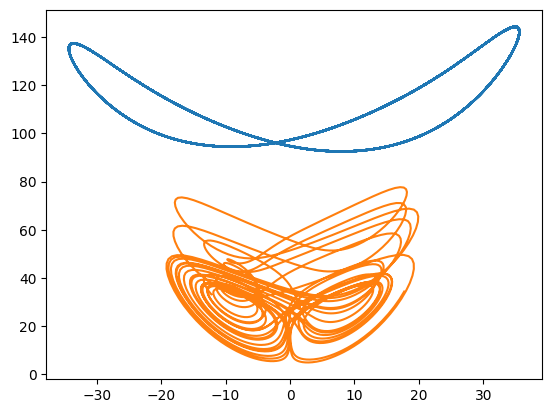

In [ ]:
def display_bifurcation_simulation(trajectories, title):
    for i in range(len(trajectories)):
        t = trajectories[i]
        x1 = t[time_ts(70):time_ts(100), 0]
        x3 = t[time_ts(70):time_ts(100), 2]
        plt.plot(x1, x3)
        # ax.set_xlim(-60, 50)
        # ax.set_ylim(-150, 250)

display_bifurcation_simulation(trajectories_list[1], "test")

In [ ]:
file_path = f'drive/My Drive/Lorenz_birth_data/continuation_for_bifurcation_from_0.013_up.pkl'

In [ ]:
save_dictionary(bifurcation_analysis_data_piece, file_path)

Dictionary saved to drive/My Drive/Lorenz_birth_data/continuation_for_bifurcation_from_0.013_up.pkl
